# scRNA-seq Analysis on DMS53 Samples
Filtering using mt percent count < 5 and < 10

In [15]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.io import mmread
# from anndata import AnnData
import anndata as ad
import matplotlib.pyplot as plt

sc.settings.verbosity = 2

## Load Data

In [3]:
REF='/mnt/monica/quaranta/Data/RNAseq/SCLC_data/SCLC_scRNAseq/SCLC-human-cell-lines-Vanderbilt/adata_no_doublets_02.h5ad'

In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_h5ad(REF)
adata

AnnData object with n_obs × n_vars = 13945 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_

13,945 cells × 20,446 genes  
`adata.var_names` are gene names `adata.obs_names` are cell IDs (barcodes) and cell line identifiers

In [9]:
adata.obs['cline']

CellID
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454    DMS454
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454    DMS454
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454    DMS454
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454    DMS454
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454    DMS454
                                                  ...  
2639-SM-2-CTTGTA_S2:TTTGTGTCGGCCCTTAx-DMS53       DMS53
2639-SM-2-CTTGTA_S2:TTTGTGTCCACAAGGCx-DMS53       DMS53
2639-SM-2-CTTGTA_S2:TTTGTGTCCTGTTCTTx-DMS53       DMS53
2639-SM-2-CTTGTA_S2:TTTGTGTCCCCATCTGx-DMS53       DMS53
2639-SM-2-CTTGTA_S2:TTTGTGTCCAGTTTGCx-DMS53       DMS53
Name: cline, Length: 13945, dtype: category
Categories (8, object): ['DMS454', 'CORL279', 'H1048', 'H82', 'H69', 'H841', 'H524', 'DMS53']

### Reading Counts Matrix 
The MTX format is a sparse matrix format with genes on the rows and cells on the columns as output by Cell Ranger (`8056-AW-0001_S1_L005_counts.mtx`)  

You should also have TSV files with genes (`8056-AW-0001_S1_L005_features.tsv`) and barcode sequences (`8056-AW-0001_S1_L005_barcodes.tsv`) corresponding to row and column indices, respectively  

| Sample Info | Output Dir |
| ------------| ------------|
| S1 H841_KOR  | 8056-AW-0001 |
| S2 H841_RESTko | 8056-AW-0002 |
| S3 H841_Hes1ko | 8056-AW-0003 | 
| S4 H841_NR0B1ko | 8056-AW-0004 |
| S5 H841_ELF3ko | 8056-AW-0005 |
| S1 DMS53_KOR | 8056-AW-0006 |
| S2 DMS53_RESTko | 8056-AW-0007 |
| S3 DMS53_Hes1ko | 8056-AW-0008 |
| S4 DMS53_NR0B1ko | 8056-AW-0009 |
| S5 DMS53_ELF3ko | 8056-AW-0010 |

In [10]:
MTX_DIR = '/mnt/monica/quaranta2/Sequence_data_from_VANTAGE/CW-AW_data/processed_data_Qi_Liu'
sample_names = os.listdir(MTX_DIR)
sample_names.sort()
sample_names = sample_names[2:12]
print(sample_names)

['8056-AW-0001', '8056-AW-0002', '8056-AW-0003', '8056-AW-0004', '8056-AW-0005', '8056-AW-0006', '8056-AW-0007', '8056-AW-0008', '8056-AW-0009', '8056-AW-0010']


In [11]:
# H841 - samples[0:5]
# DMS53 - samples[5:10]
cache = False
cache_compression = None
samples = []

for sample in sample_names[5:10]:
    print(sample)
    s = sc.read(
        f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_counts.mtx',
        cache=cache,
        cache_compression=cache_compression,
    ).T
    
    genes = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_features.tsv', header=None, sep='\t')
    s.var_names = genes[0]
    # s.var['gene_symbols'] = genes[1].values
    s.obs_names = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_barcodes.tsv', header=None)[0]
    print(s)
    samples.append(s)

8056-AW-0006
AnnData object with n_obs × n_vars = 12622 × 25828
8056-AW-0007
AnnData object with n_obs × n_vars = 13303 × 25856
8056-AW-0008
AnnData object with n_obs × n_vars = 5038 × 24030
8056-AW-0009
AnnData object with n_obs × n_vars = 7962 × 26426
8056-AW-0010
AnnData object with n_obs × n_vars = 10536 × 26090


In [21]:
# Concatenate and add labels
s1, s2, s3, s4, s5 = samples
adatas = {
    "S1 DMS53_KOR": s1,
    "S2 DMS53_RESTko": s2,
    "S3 DMS53_Hes1ko": s3,
    "S4 DMS53_NR0B1ko": s4,
    "S5 DMS53_ELF3ko": s5
}

# two copies for each of the filtering methods
mt5_adata = ad.concat(adatas, label="sample", join="outer", index_unique="_")
mt10_adata = ad.concat(adatas, label="sample", join="outer", index_unique="_")

In [22]:
mt5_adata

AnnData object with n_obs × n_vars = 49461 × 29815
    obs: 'sample'

In [23]:
mt5_adata.obs

sample
CTTCAGGTGGCATGCT_S1 DMS53_KOR           S1 DMS53_KOR
GGCCCTTAGATTTACC_S1 DMS53_KOR           S1 DMS53_KOR
TGATTCGCTGGTTTGGGAG_S1 DMS53_KOR        S1 DMS53_KOR
AGCAACCTGCGGGCTTT_S1 DMS53_KOR          S1 DMS53_KOR
GATGACGGACCCCATCTG_S1 DMS53_KOR         S1 DMS53_KOR
...                                              ...
GATGTTCCAGGTCCATGT_S5 DMS53_ELF3ko   S5 DMS53_ELF3ko
GATGTGAGACCTTCTT_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko
GGCCCTTAAGGCAGTT_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko
CTTTAATCATGAAGCA_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko
TGAAGCGCGATAGCGCCTT_S5 DMS53_ELF3ko  S5 DMS53_ELF3ko

[49461 rows x 1 columns]

## DMS53 with pct_counts_mt < 5
### Preprocessing

normalizing counts per cell
    finished (0:00:00)


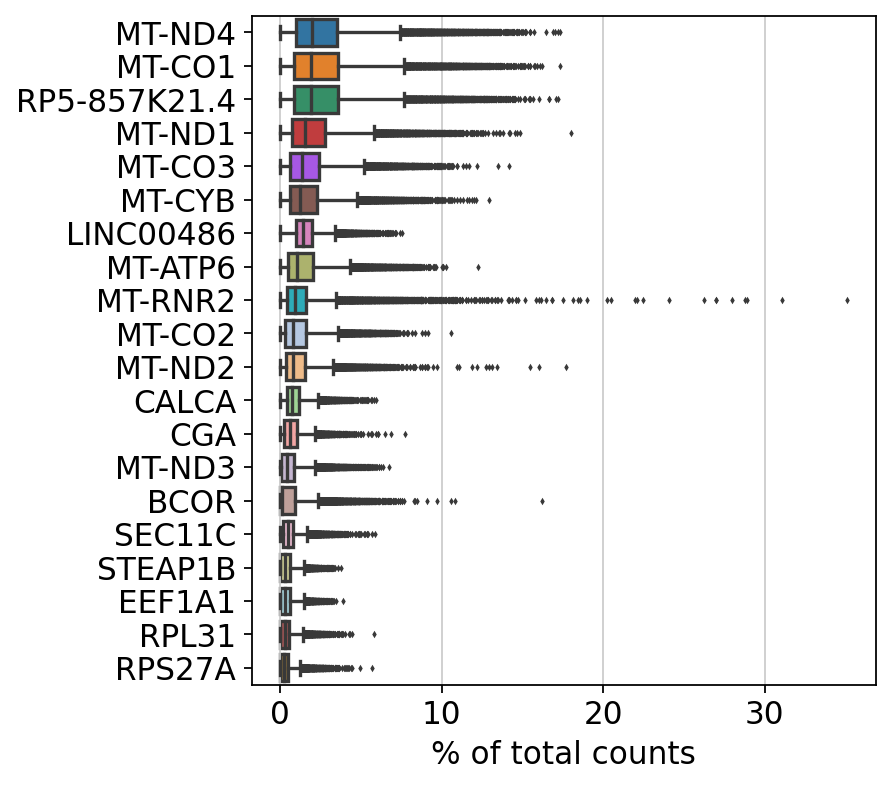

In [24]:
sc.pl.highest_expr_genes(mt5_adata, n_top=20, )

In [25]:
sc.pp.filter_cells(mt5_adata, min_genes=200)
sc.pp.filter_genes(mt5_adata, min_cells=3)

filtered out 18501 cells that have less than 200 genes expressed
filtered out 3581 genes that are detected in less than 3 cells


In [26]:
mt5_adata

AnnData object with n_obs × n_vars = 30960 × 26234
    obs: 'sample', 'n_genes'
    var: 'n_cells'

In [27]:
mt5_adata.var['mt'] = mt5_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [28]:
mt5_adata.var

n_cells     mt
7SK                 3  False
A1BG               10  False
A1CF              332  False
A2M               218  False
A2M-AS1            16  False
...               ...    ...
bP-21264C1.2      207  False
bP-2171C21.3     5153  False
bP-2189O9.3       272  False
snoU13              7  False
uc_338              5  False

[26234 rows x 2 columns]

In [ ]:
mt5_adata.var[mt5_adata.var.mt == True]

In [30]:
sc.pp.calculate_qc_metrics(mt5_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [31]:
mt5_adata.obs

sample  n_genes  \
TAGCTTATTGTAGTTT_S1 DMS53_KOR           S1 DMS53_KOR      200   
ACTTCAATCGTATTTC_S1 DMS53_KOR           S1 DMS53_KOR      200   
TGACAATACTTCAGTCCCT_S1 DMS53_KOR        S1 DMS53_KOR      200   
GAATTGGGCCTTCCAGAC_S1 DMS53_KOR         S1 DMS53_KOR      200   
GACAATTAGTCCCATAGC_S1 DMS53_KOR         S1 DMS53_KOR      200   
...                                              ...      ...   
GATGTTCCAGGTCCATGT_S5 DMS53_ELF3ko   S5 DMS53_ELF3ko     7131   
GATGTGAGACCTTCTT_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko     7195   
GGCCCTTAAGGCAGTT_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko     7715   
CTTTAATCATGAAGCA_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko     7771   
TGAAGCGCGATAGCGCCTT_S5 DMS53_ELF3ko  S5 DMS53_ELF3ko     8568   

                                     n_genes_by_counts  total_counts  \
TAGCTTATTGTAGTTT_S1 DMS53_KOR                      200         224.0   
ACTTCAATCGTATTTC_S1 DMS53_KOR                      200         224.0   
TGACAATACTTCAGTCCCT_S1 DMS53_KOR                   200         224.0   
GAATTGGGCCTTCCAGAC_S1 DMS53_KOR                    200         225.0   
GACAATTAGTCCCATAGC_S1 DMS53_KOR                    200         225.0   
...                                                ...           ...   
GATGTTCCAGGTCCATGT_S5 DMS53_ELF3ko                7129       30916.0   
GATGTGAGACCTTCTT_S5 DMS53_ELF3ko                  7193       30642.0   
GGCCCTTAAGGCAGTT_S5 DMS53_ELF3ko                  7713       33783.0   
CTTTAATCATGAAGCA_S5 DMS53_ELF3ko                  7770       35862.0   
TGAAGCGCGATAGCGCCTT_S5 DMS53_ELF3ko               8560       43419.0   

                                     total_counts_mt  pct_counts_mt  
TAGCTTATTGTAGTTT_S1 DMS53_KOR                   11.0       4.910714  
ACTTCAATCGTATTTC_S1 DMS53_KOR                   16.0       7.142858  
TGACAATACTTCAGTCCCT_S1 DMS53_KOR                10.0       4.464286  
GAATTGGGCCTTCCAGAC_S1 DMS53_KOR                  5.0       2.222222  
GACAATTAGTCCCATAGC_S1 DMS53_KOR                 10.0       4.444445  
...                                              ...            ...  
GATGTTCCAGGTCCATGT_S5 DMS53_ELF3ko            3597.0      11.634752  
GATGTGAGACCTTCTT_S5 DMS53_ELF3ko              1152.0       3.759546  
GGCCCTTAAGGCAGTT_S5 DMS53_ELF3ko              4328.0      12.811176  
CTTTAATCATGAAGCA_S5 DMS53_ELF3ko              3644.0      10.161173  
TGAAGCGCGATAGCGCCTT_S5 DMS53_ELF3ko           7506.0      17.287363  

[30960 rows x 6 columns]

<AxesSubplot:>

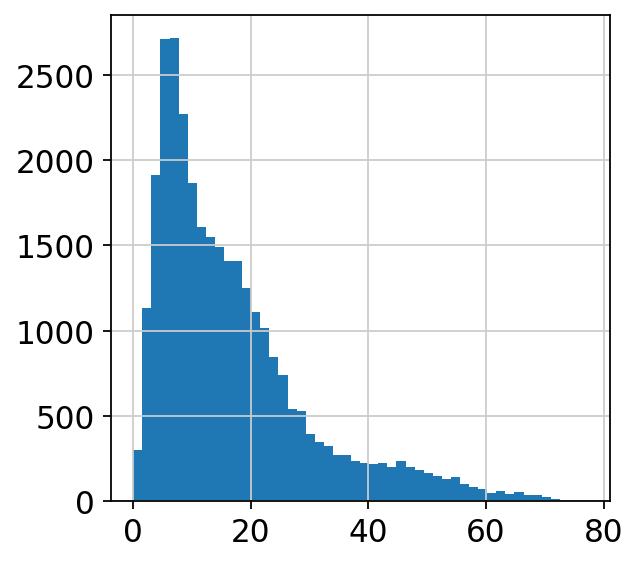

In [32]:
mt5_adata.obs['pct_counts_mt'].hist(bins=50)

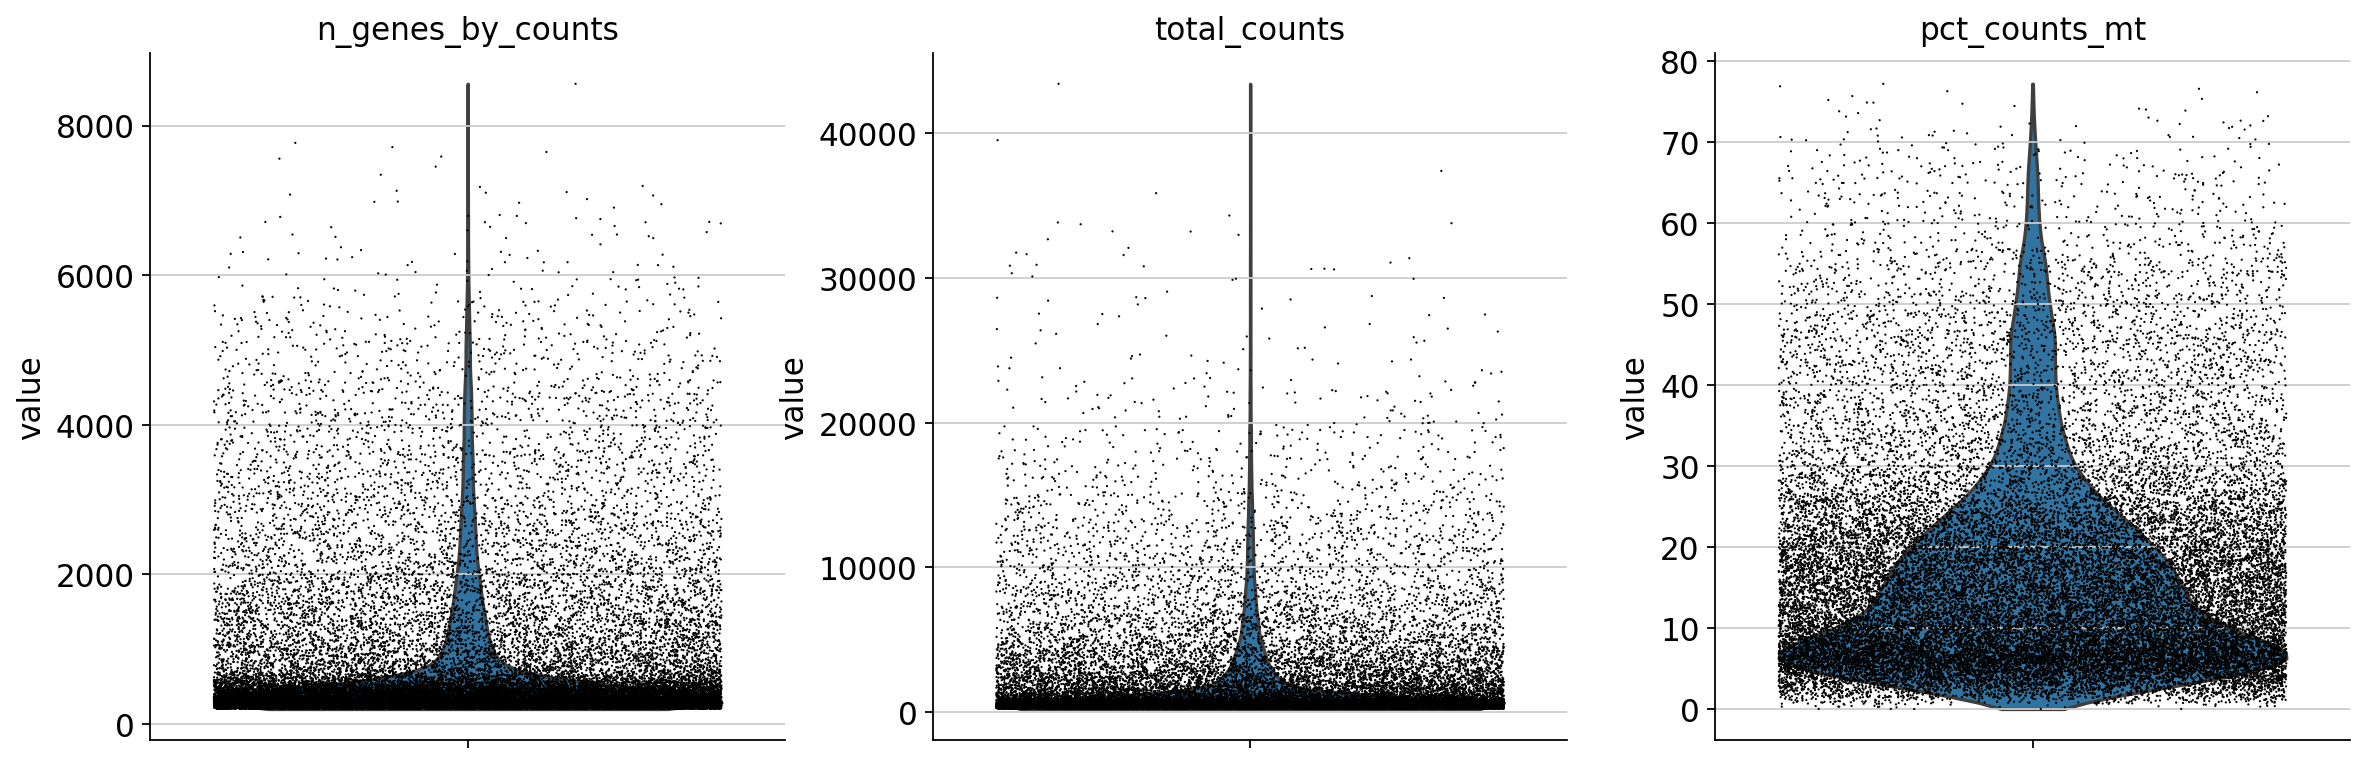

In [33]:
sc.pl.violin(mt5_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

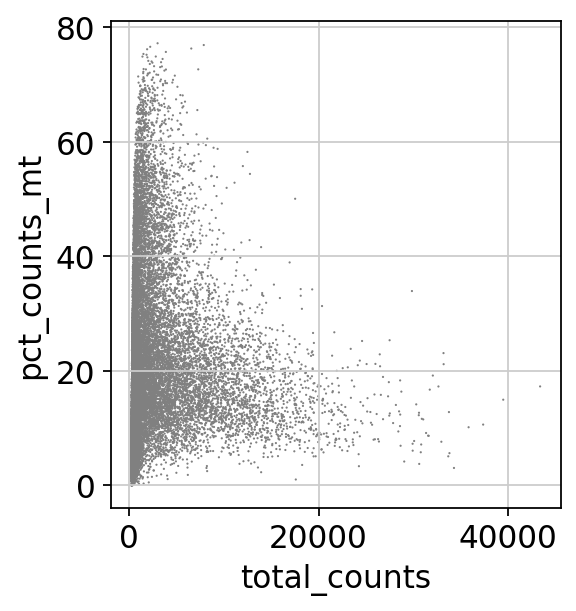

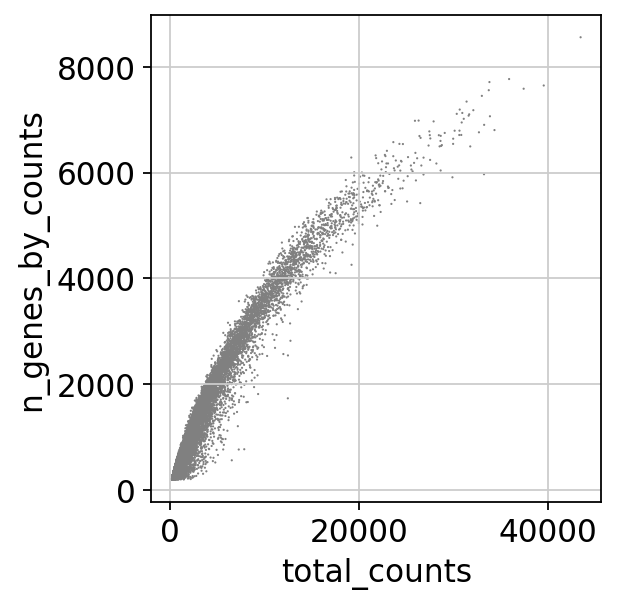

In [34]:
sc.pl.scatter(mt5_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(mt5_adata, x='total_counts', y='n_genes_by_counts')

### Filtering

In [35]:
# filtering by quantile instead of picking a limit and slicing, like in the tutorial 
# (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]

upper_lim = np.quantile(mt5_adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(mt5_adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

205.0 to 4431.82


In [36]:
# filtering by upper and lower limits
mt5_adata = mt5_adata[(mt5_adata.obs.n_genes_by_counts < upper_lim) & (mt5_adata.obs.n_genes_by_counts > lower_lim)]
mt5_adata = mt5_adata[mt5_adata.obs.pct_counts_mt < 5, :] # from 30,000 to 3,800 cells

In [37]:
mt5_adata.obs

sample  n_genes  \
CGCTAATATACTTGTG_S1 DMS53_KOR          S1 DMS53_KOR      206   
TGAAGAAGTTATCACCGAG_S1 DMS53_KOR       S1 DMS53_KOR      206   
TGACCTGTTATCGATTGAT_S1 DMS53_KOR       S1 DMS53_KOR      206   
GAACCACGCTCCCTTCAG_S1 DMS53_KOR        S1 DMS53_KOR      206   
GACCTACTAGAATCGGGT_S1 DMS53_KOR        S1 DMS53_KOR      206   
...                                             ...      ...   
GAGAGCCCATACTTCAAT_S5 DMS53_ELF3ko  S5 DMS53_ELF3ko     1224   
TACAGCCGCTTGGTGT_S5 DMS53_ELF3ko    S5 DMS53_ELF3ko     1242   
CCCATCTGATGGATTA_S5 DMS53_ELF3ko    S5 DMS53_ELF3ko     1331   
AAAAGTCGGTCATGAGG_S5 DMS53_ELF3ko   S5 DMS53_ELF3ko     1725   
GATTAGACAAACTCGA_S5 DMS53_ELF3ko    S5 DMS53_ELF3ko     2106   

                                    n_genes_by_counts  total_counts  \
CGCTAATATACTTGTG_S1 DMS53_KOR                     206         223.0   
TGAAGAAGTTATCACCGAG_S1 DMS53_KOR                  206         226.0   
TGACCTGTTATCGATTGAT_S1 DMS53_KOR                  206         228.0   
GAACCACGCTCCCTTCAG_S1 DMS53_KOR                   206         231.0   
GACCTACTAGAATCGGGT_S1 DMS53_KOR                   206         233.0   
...                                               ...           ...   
GAGAGCCCATACTTCAAT_S5 DMS53_ELF3ko               1224        1709.0   
TACAGCCGCTTGGTGT_S5 DMS53_ELF3ko                 1242        2132.0   
CCCATCTGATGGATTA_S5 DMS53_ELF3ko                 1330        2232.0   
AAAAGTCGGTCATGAGG_S5 DMS53_ELF3ko                1725        3366.0   
GATTAGACAAACTCGA_S5 DMS53_ELF3ko                 2106        4055.0   

                                    total_counts_mt  pct_counts_mt  
CGCTAATATACTTGTG_S1 DMS53_KOR                   4.0       1.793722  
TGAAGAAGTTATCACCGAG_S1 DMS53_KOR                3.0       1.327434  
TGACCTGTTATCGATTGAT_S1 DMS53_KOR                3.0       1.315789  
GAACCACGCTCCCTTCAG_S1 DMS53_KOR                 2.0       0.865801  
GACCTACTAGAATCGGGT_S1 DMS53_KOR                 9.0       3.862661  
...                                             ...            ...  
GAGAGCCCATACTTCAAT_S5 DMS53_ELF3ko             71.0       4.154476  
TACAGCCGCTTGGTGT_S5 DMS53_ELF3ko               61.0       2.861163  
CCCATCTGATGGATTA_S5 DMS53_ELF3ko              104.0       4.659498  
AAAAGTCGGTCATGAGG_S5 DMS53_ELF3ko              65.0       1.931075  
GATTAGACAAACTCGA_S5 DMS53_ELF3ko               45.0       1.109741  

[3801 rows x 6 columns]

In [38]:
mt5_adata.X[1,:].sum() # before normalizing

226.0

In [39]:
sc.pp.normalize_total(mt5_adata, target_sum=1e4) # normalize every cell to 10,000 UMI

normalizing counts per cell
    finished (0:00:00)


/home/monica/miniconda/envs/rna-seq/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [40]:
mt5_adata.X[1,:].sum() # after normalizing

9999.992

In [41]:
sc.pp.log1p(mt5_adata) # change to log counts

## Clustering

In [42]:
sc.pp.highly_variable_genes(mt5_adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # default values

extracting highly variable genes
    finished (0:00:00)


In [43]:
mt5_adata.var[mt5_adata.var.highly_variable] # filter highly variable

n_cells     mt  n_cells_by_counts  mean_counts  \
A1CF                     332  False                332     0.012080   
AAAS                    1981  False               1981     0.080782   
AAED1                    280  False                280     0.009722   
AATF                    1713  False               1713     0.066279   
ABC13-47656900H15.1      105  False                105     0.003456   
...                      ...    ...                ...          ...   
ZSCAN31                 1019  False               1019     0.038469   
ZSWIM4                   615  False                615     0.022481   
ZSWIM6                  1846  False               1846     0.076227   
ZUFSP                    848  False                848     0.030652   
ZWILCH                  1229  False               1229     0.048450   

                     pct_dropout_by_counts  total_counts  highly_variable  \
A1CF                             98.927649         374.0             True   
AAAS                             93.601421        2501.0             True   
AAED1                            99.095607         301.0             True   
AATF                             94.467054        2052.0             True   
ABC13-47656900H15.1              99.660853         107.0             True   
...                                    ...           ...              ...   
ZSCAN31                          96.708656        1191.0             True   
ZSWIM4                           98.013566         696.0             True   
ZSWIM6                           94.037468        2360.0             True   
ZUFSP                            97.260982         949.0             True   
ZWILCH                           96.030362        1500.0             True   

                        means  dispersions  dispersions_norm  
A1CF                 0.072484     3.390443          0.507046  
AAAS                 0.502473     3.389067          0.599655  
AAED1                0.059749     3.451296          0.604776  
AATF                 0.391531     3.381727          0.657911  
ABC13-47656900H15.1  0.017070     3.440050          0.586714  
...                       ...          ...               ...  
ZSCAN31              0.196224     3.389496          0.505526  
ZSWIM4               0.102240     3.590311          0.828035  
ZSWIM6               0.244980     3.480262          0.651296  
ZUFSP                0.262471     3.401853          0.871776  
ZWILCH               0.399666     3.385360          0.696519  

[3308 rows x 10 columns]

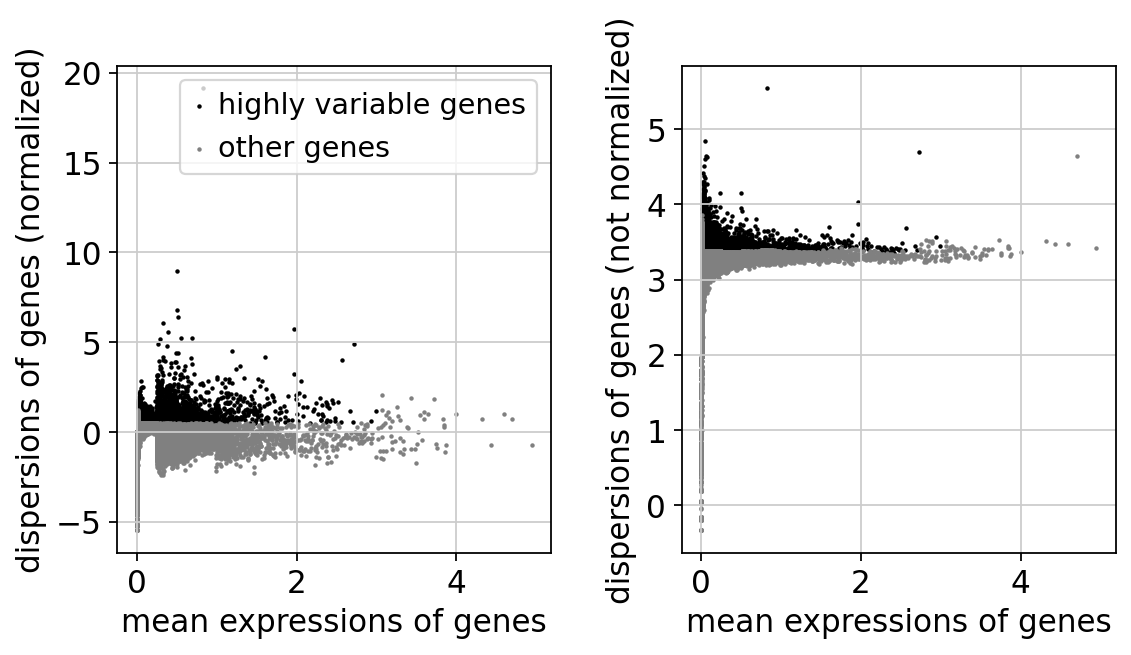

In [44]:
sc.pl.highly_variable_genes(mt5_adata)

In [45]:
mt5_adata.raw = mt5_adata # save raw data before processing and filtering further

In [46]:
mt5_adata = mt5_adata[:, mt5_adata.var.highly_variable] # filter highly variable

In [47]:
mt5_adata

View of AnnData object with n_obs × n_vars = 3801 × 3308
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [48]:
# regress out effects of total counts per cell and percentage of mitochondrial genes expressed
sc.pp.regress_out(mt5_adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


In [49]:
sc.pp.scale(mt5_adata, max_value=10) # scale each gene to unit variance

In [50]:
mt5_adata.X.min()

-5.6512947

In [51]:
mt5_adata.raw.X.min()

0.0

### Prinicipal Component Analysis

In [52]:
sc.tl.pca(mt5_adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


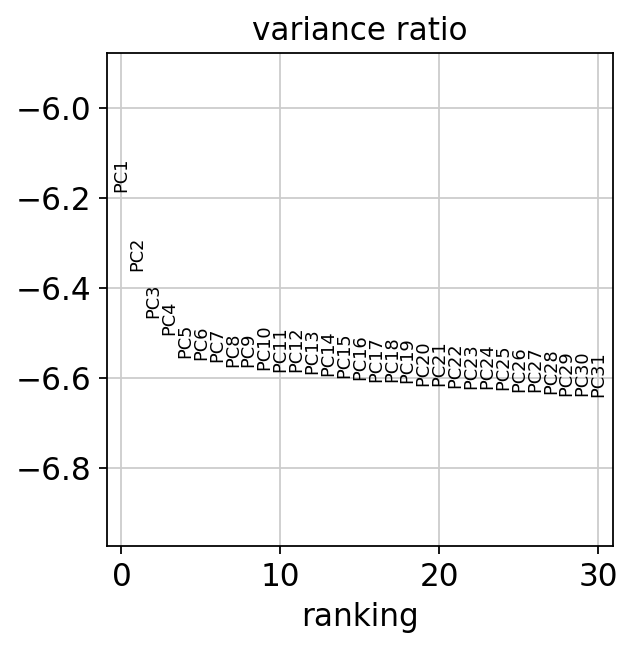

In [53]:
sc.pl.pca_variance_ratio(mt5_adata, log=True)

In [54]:
mt5_adata.write('/home/monica/rna_seq/dms53_mt5_adata.h5ad')

### Neighborhood Graph

In [55]:
sc.pp.neighbors(mt5_adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30


/home/monica/miniconda/envs/rna-seq/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:00:04)


In [56]:
sc.tl.umap(mt5_adata)

computing UMAP
    finished (0:00:06)


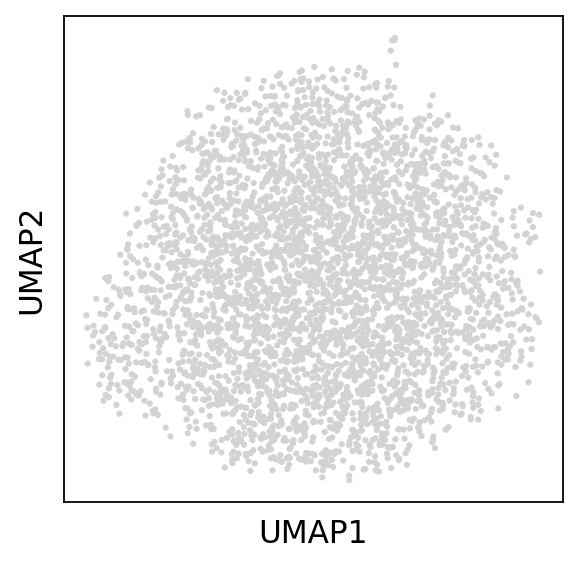

In [57]:
sc.pl.umap(mt5_adata)

running Leiden clustering
    finished (0:00:00)


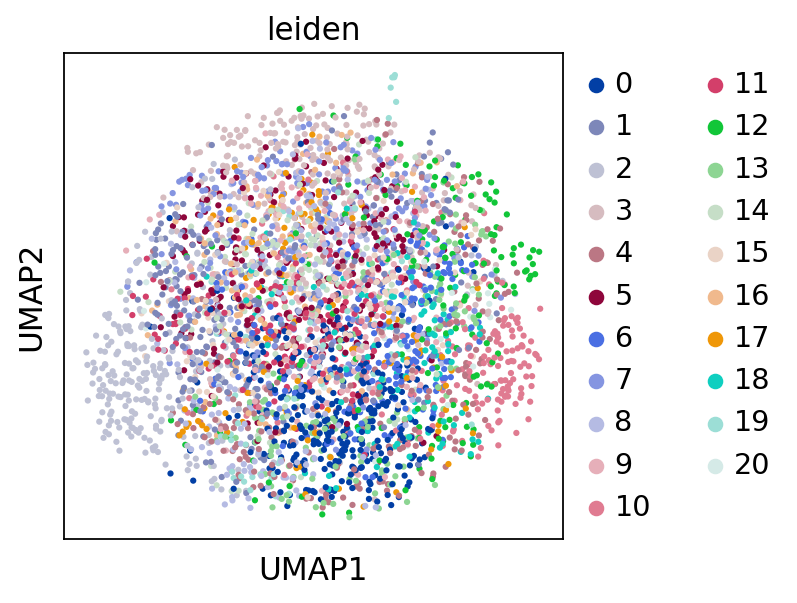

In [58]:
sc.tl.leiden(mt5_adata) # not sure if resolution needs to be specified here
sc.pl.umap(mt5_adata, color=['leiden'])

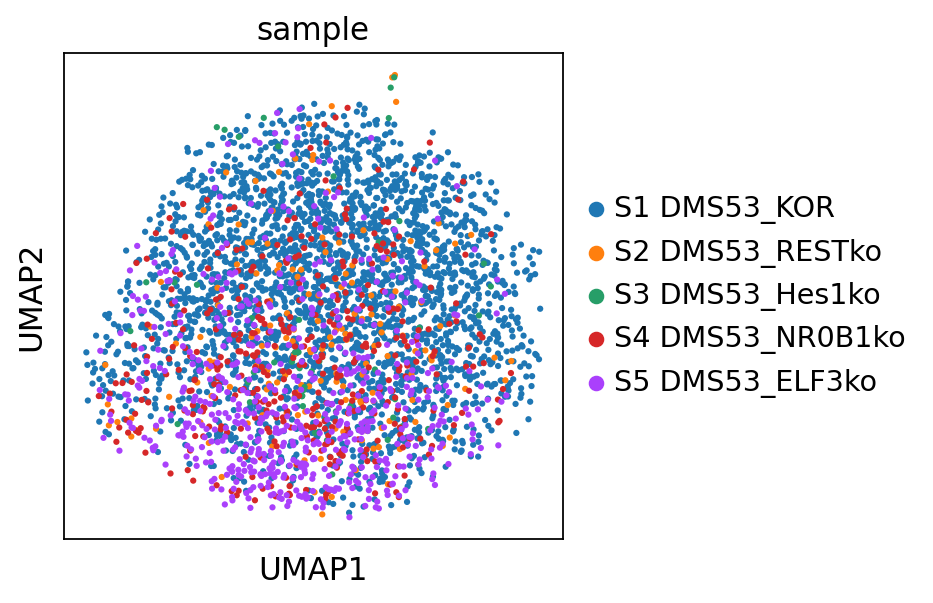

In [59]:
sc.pl.umap(mt5_adata, color=['sample'])

## DMS53 with pct_counts_mt < 10
### Preprocessing - will be the same as mt < 5

In [60]:
sc.pp.filter_cells(mt10_adata, min_genes=200)
sc.pp.filter_genes(mt10_adata, min_cells=3)

filtered out 18501 cells that have less than 200 genes expressed
filtered out 3581 genes that are detected in less than 3 cells


In [61]:
mt10_adata.var['mt'] = mt10_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [ ]:
mt10_adata.var[mt10_adata.var.mt == True]

In [64]:
sc.pp.calculate_qc_metrics(mt10_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [65]:
mt10_adata.obs

sample  n_genes  \
TAGCTTATTGTAGTTT_S1 DMS53_KOR           S1 DMS53_KOR      200   
ACTTCAATCGTATTTC_S1 DMS53_KOR           S1 DMS53_KOR      200   
TGACAATACTTCAGTCCCT_S1 DMS53_KOR        S1 DMS53_KOR      200   
GAATTGGGCCTTCCAGAC_S1 DMS53_KOR         S1 DMS53_KOR      200   
GACAATTAGTCCCATAGC_S1 DMS53_KOR         S1 DMS53_KOR      200   
...                                              ...      ...   
GATGTTCCAGGTCCATGT_S5 DMS53_ELF3ko   S5 DMS53_ELF3ko     7131   
GATGTGAGACCTTCTT_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko     7195   
GGCCCTTAAGGCAGTT_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko     7715   
CTTTAATCATGAAGCA_S5 DMS53_ELF3ko     S5 DMS53_ELF3ko     7771   
TGAAGCGCGATAGCGCCTT_S5 DMS53_ELF3ko  S5 DMS53_ELF3ko     8568   

                                     n_genes_by_counts  total_counts  \
TAGCTTATTGTAGTTT_S1 DMS53_KOR                      200         224.0   
ACTTCAATCGTATTTC_S1 DMS53_KOR                      200         224.0   
TGACAATACTTCAGTCCCT_S1 DMS53_KOR                   200         224.0   
GAATTGGGCCTTCCAGAC_S1 DMS53_KOR                    200         225.0   
GACAATTAGTCCCATAGC_S1 DMS53_KOR                    200         225.0   
...                                                ...           ...   
GATGTTCCAGGTCCATGT_S5 DMS53_ELF3ko                7129       30916.0   
GATGTGAGACCTTCTT_S5 DMS53_ELF3ko                  7193       30642.0   
GGCCCTTAAGGCAGTT_S5 DMS53_ELF3ko                  7713       33783.0   
CTTTAATCATGAAGCA_S5 DMS53_ELF3ko                  7770       35862.0   
TGAAGCGCGATAGCGCCTT_S5 DMS53_ELF3ko               8560       43419.0   

                                     total_counts_mt  pct_counts_mt  
TAGCTTATTGTAGTTT_S1 DMS53_KOR                   11.0       4.910714  
ACTTCAATCGTATTTC_S1 DMS53_KOR                   16.0       7.142858  
TGACAATACTTCAGTCCCT_S1 DMS53_KOR                10.0       4.464286  
GAATTGGGCCTTCCAGAC_S1 DMS53_KOR                  5.0       2.222222  
GACAATTAGTCCCATAGC_S1 DMS53_KOR                 10.0       4.444445  
...                                              ...            ...  
GATGTTCCAGGTCCATGT_S5 DMS53_ELF3ko            3597.0      11.634752  
GATGTGAGACCTTCTT_S5 DMS53_ELF3ko              1152.0       3.759546  
GGCCCTTAAGGCAGTT_S5 DMS53_ELF3ko              4328.0      12.811176  
CTTTAATCATGAAGCA_S5 DMS53_ELF3ko              3644.0      10.161173  
TGAAGCGCGATAGCGCCTT_S5 DMS53_ELF3ko           7506.0      17.287363  

[30960 rows x 6 columns]

### Filtering

In [66]:
# filtering by quantile instead of picking a limit and slicing, like in the tutorial 
# (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]

upper_lim = np.quantile(mt10_adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(mt10_adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

205.0 to 4431.82


In [67]:
# filtering by upper and lower limits
mt10_adata = mt10_adata[(mt10_adata.obs.n_genes_by_counts < upper_lim) & (mt10_adata.obs.n_genes_by_counts > lower_lim)]
mt10_adata = mt10_adata[mt10_adata.obs.pct_counts_mt < 10, :] # from 30,960 to 11,466 cells

In [68]:
mt10_adata.obs

sample  n_genes  \
CGCTAATATACTTGTG_S1 DMS53_KOR          S1 DMS53_KOR      206   
TGAAGAAGTTATCACCGAG_S1 DMS53_KOR       S1 DMS53_KOR      206   
TGACCTGTTATCGATTGAT_S1 DMS53_KOR       S1 DMS53_KOR      206   
GAACCACGCTCCCTTCAG_S1 DMS53_KOR        S1 DMS53_KOR      206   
GACCTACTAGAATCGGGT_S1 DMS53_KOR        S1 DMS53_KOR      206   
...                                             ...      ...   
TTATAGCCATATGCAT_S5 DMS53_ELF3ko    S5 DMS53_ELF3ko     4283   
GAGTTTCGTCATCCTT_S5 DMS53_ELF3ko    S5 DMS53_ELF3ko     4299   
GATGTGAGGAAGTGCC_S5 DMS53_ELF3ko    S5 DMS53_ELF3ko     4303   
GAGAATACGCAGCGCGAT_S5 DMS53_ELF3ko  S5 DMS53_ELF3ko     4384   
TGCCTCACACCCACGA_S5 DMS53_ELF3ko    S5 DMS53_ELF3ko     4398   

                                    n_genes_by_counts  total_counts  \
CGCTAATATACTTGTG_S1 DMS53_KOR                     206         223.0   
TGAAGAAGTTATCACCGAG_S1 DMS53_KOR                  206         226.0   
TGACCTGTTATCGATTGAT_S1 DMS53_KOR                  206         228.0   
GAACCACGCTCCCTTCAG_S1 DMS53_KOR                   206         231.0   
GACCTACTAGAATCGGGT_S1 DMS53_KOR                   206         233.0   
...                                               ...           ...   
TTATAGCCATATGCAT_S5 DMS53_ELF3ko                 4280       10426.0   
GAGTTTCGTCATCCTT_S5 DMS53_ELF3ko                 4298       11987.0   
GATGTGAGGAAGTGCC_S5 DMS53_ELF3ko                 4302       11766.0   
GAGAATACGCAGCGCGAT_S5 DMS53_ELF3ko               4384       12534.0   
TGCCTCACACCCACGA_S5 DMS53_ELF3ko                 4398       13792.0   

                                    total_counts_mt  pct_counts_mt  
CGCTAATATACTTGTG_S1 DMS53_KOR                   4.0       1.793722  
TGAAGAAGTTATCACCGAG_S1 DMS53_KOR                3.0       1.327434  
TGACCTGTTATCGATTGAT_S1 DMS53_KOR                3.0       1.315789  
GAACCACGCTCCCTTCAG_S1 DMS53_KOR                 2.0       0.865801  
GACCTACTAGAATCGGGT_S1 DMS53_KOR                 9.0       3.862661  
...                                             ...            ...  
TTATAGCCATATGCAT_S5 DMS53_ELF3ko              883.0       8.469212  
GAGTTTCGTCATCCTT_S5 DMS53_ELF3ko             1130.0       9.426879  
GATGTGAGGAAGTGCC_S5 DMS53_ELF3ko              881.0       7.487676  
GAGAATACGCAGCGCGAT_S5 DMS53_ELF3ko           1246.0       9.940960  
TGCCTCACACCCACGA_S5 DMS53_ELF3ko             1351.0       9.795534  

[11466 rows x 6 columns]

In [69]:
sc.pp.normalize_total(mt10_adata, target_sum=1e4) # normalize every cell to 10,000 UMI

normalizing counts per cell
    finished (0:00:00)


/home/monica/miniconda/envs/rna-seq/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [70]:
sc.pp.log1p(mt10_adata) # change to log counts

### Clustering

In [71]:
sc.pp.highly_variable_genes(mt10_adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # default values

extracting highly variable genes
    finished (0:00:00)


In [72]:
mt10_adata.var[mt10_adata.var.highly_variable] # highly variable

n_cells     mt  n_cells_by_counts  mean_counts  \
A2M          218  False                218     0.007881   
AAAS        1981  False               1981     0.080782   
ABCA4        173  False                173     0.006105   
ABCB10       764  False                764     0.028165   
ABCE1       1590  False               1590     0.061919   
...          ...    ...                ...          ...   
ZSCAN22      205  False                205     0.006912   
ZSCAN25      425  False                425     0.015988   
ZSCAN30      322  False                322     0.011176   
ZSWIM4       615  False                615     0.022481   
ZSWIM6      1846  False               1846     0.076227   

         pct_dropout_by_counts  total_counts  highly_variable     means  \
A2M                  99.295866         244.0             True  0.024116   
AAAS                 93.601421        2501.0             True  0.466060   
ABCA4                99.441214         189.0             True  0.036217   
ABCB10               97.532300         872.0             True  0.167498   
ABCE1                94.864341        1917.0             True  0.477742   
...                        ...           ...              ...       ...   
ZSCAN22              99.337855         214.0             True  0.032637   
ZSCAN25              98.627261         495.0             True  0.097546   
ZSCAN30              98.959948         346.0             True  0.065032   
ZSWIM4               98.013566         696.0             True  0.086192   
ZSWIM6               94.037468        2360.0             True  0.213771   

         dispersions  dispersions_norm  
A2M         3.335640          0.614833  
AAAS        3.281294          0.727355  
ABCA4       3.342000          0.623073  
ABCB10      3.295754          0.563162  
ABCE1       3.285278          0.776362  
...              ...               ...  
ZSCAN22     3.248151          0.501491  
ZSCAN25     3.265241          0.523632  
ZSCAN30     3.326625          0.603155  
ZSWIM4      3.298709          0.566989  
ZSWIM6      3.253561          0.508500  

[3828 rows x 10 columns]

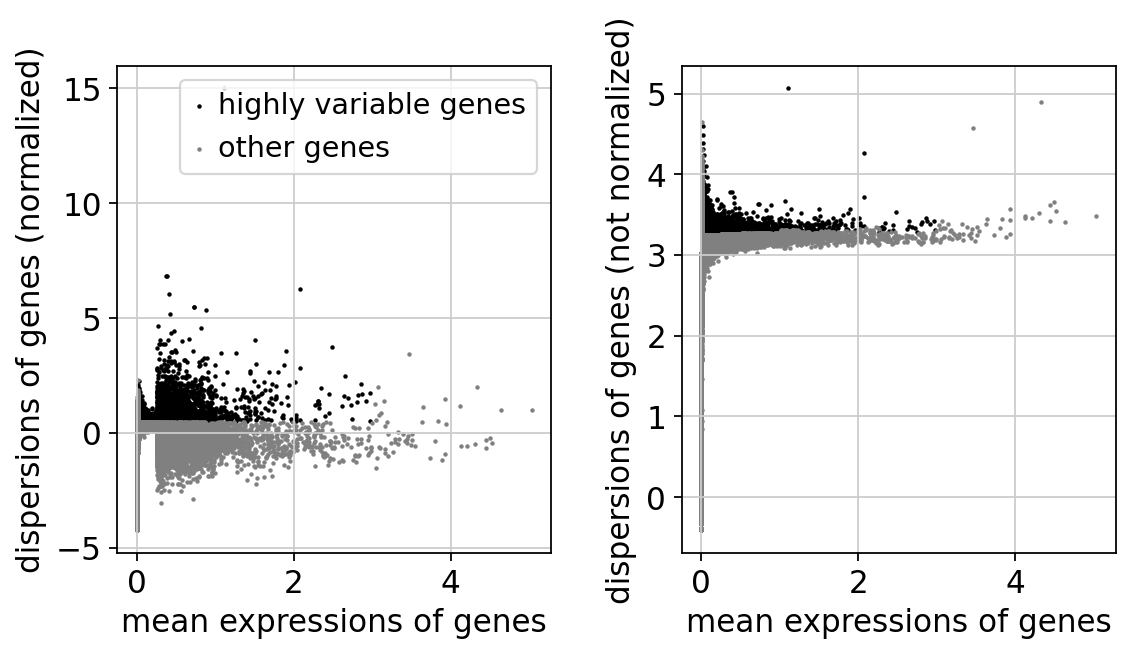

In [73]:
sc.pl.highly_variable_genes(mt10_adata)

In [74]:
mt10_adata.raw = mt10_adata # save raw data before processing and filtering further

In [75]:
mt10_adata = mt10_adata[:, mt10_adata.var.highly_variable] # filter highly variable

In [76]:
mt10_adata

View of AnnData object with n_obs × n_vars = 11466 × 3828
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [77]:
# regress out effects of total counts per cell and percentage of mitochondrial genes expressed
sc.pp.regress_out(mt10_adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:33)


In [78]:
sc.pp.scale(mt10_adata, max_value=10) # scale each gene to unit variance

In [79]:
mt10_adata.X.min()

-3.4744666

### Principal Component Analysis

In [80]:
sc.tl.pca(mt10_adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


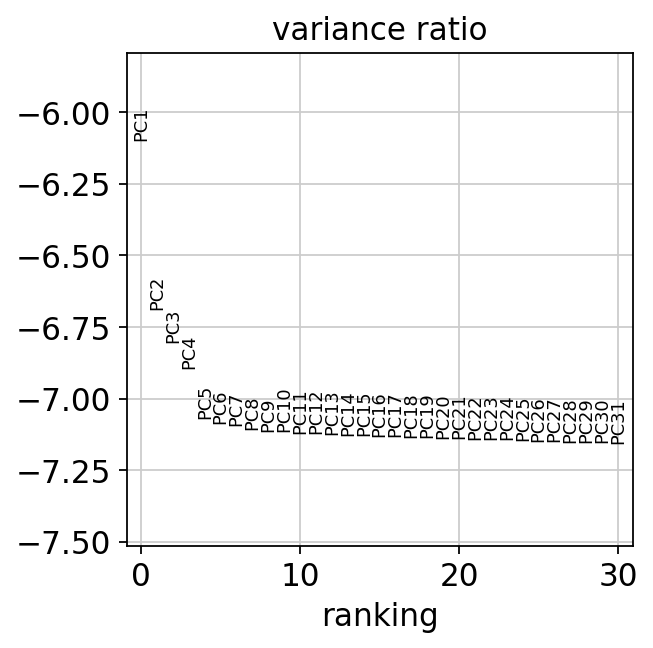

In [81]:
sc.pl.pca_variance_ratio(mt10_adata, log=True)

In [82]:
mt10_adata.write('/home/monica/rna_seq/dms53_mt10_adata.h5ad')

### Neighborhood Graph

In [83]:
sc.pp.neighbors(mt10_adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:12)


In [84]:
sc.tl.umap(mt10_adata)

computing UMAP
    finished (0:00:07)


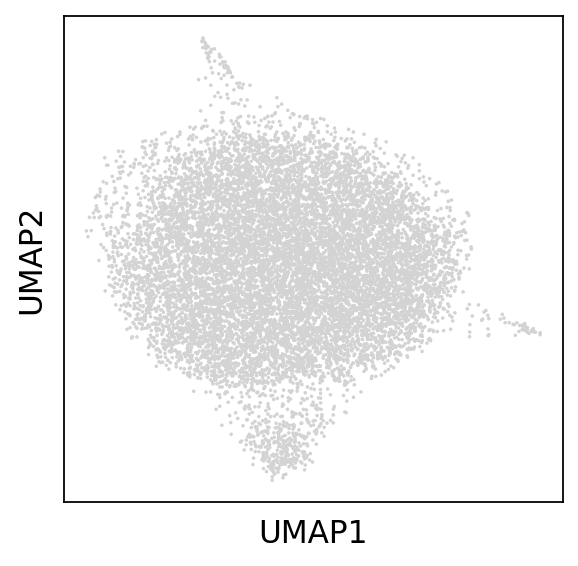

In [85]:
sc.pl.umap(mt10_adata)

running Leiden clustering
    finished (0:00:02)


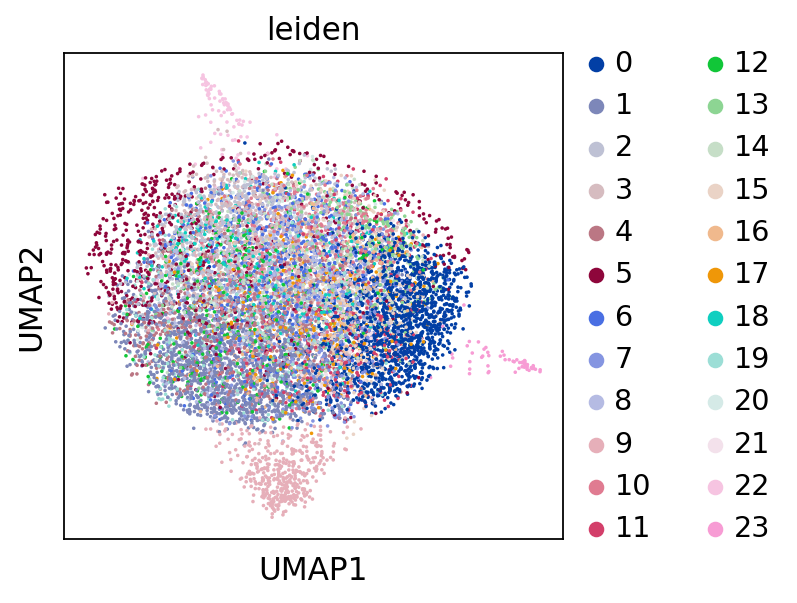

In [86]:
sc.tl.leiden(mt10_adata) # not sure if resolution needs to be specified here
sc.pl.umap(mt10_adata, color=['leiden'])

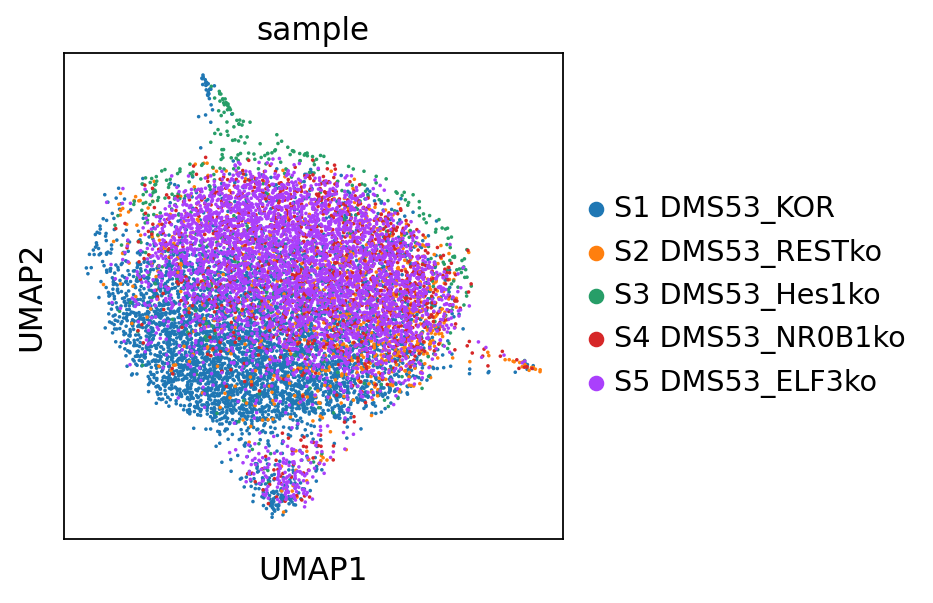

In [87]:
sc.pl.umap(mt10_adata, color=['sample'])

## Comparing UMAPS

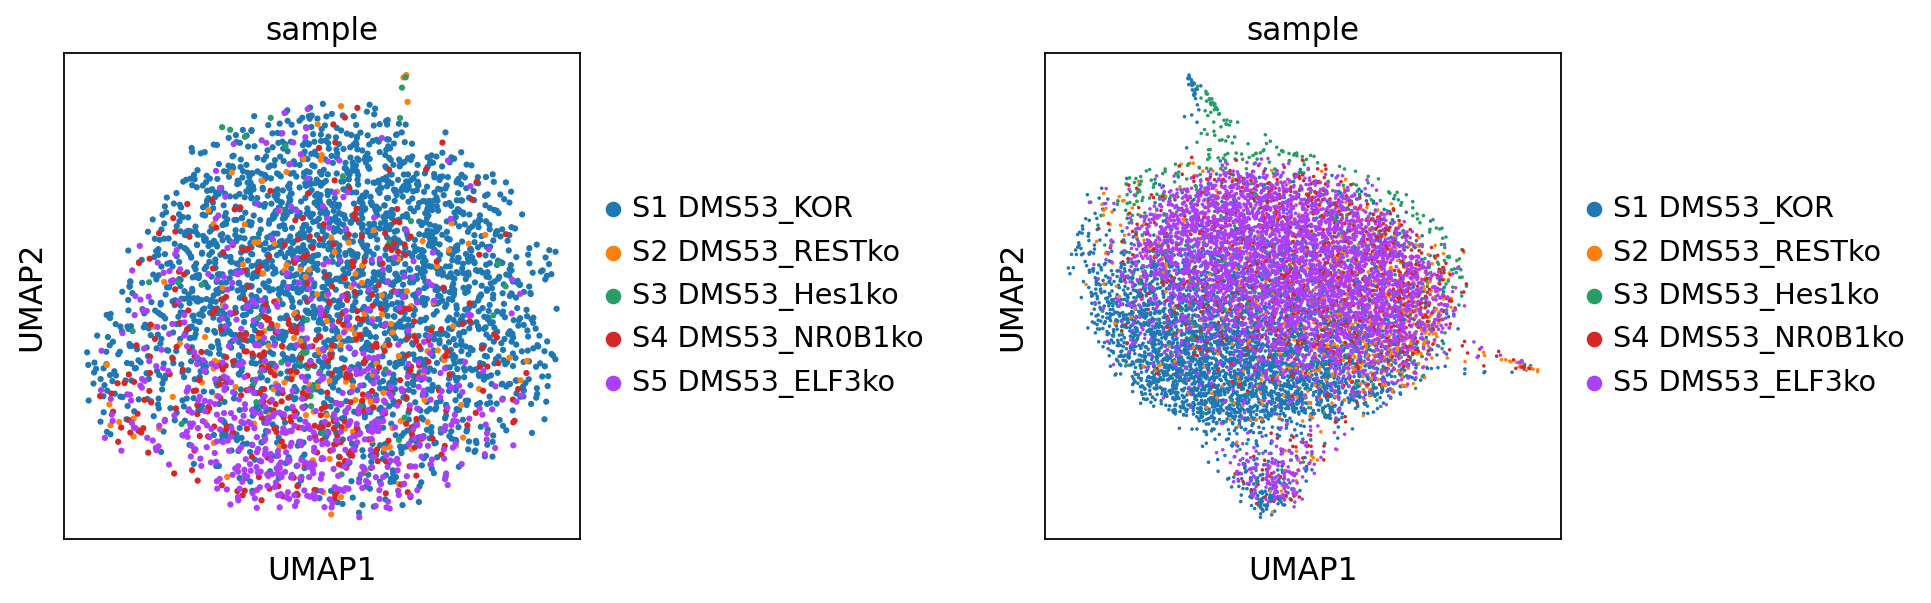

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'wspace':0.9})
ax1_dict = sc.pl.umap(mt5_adata, color=['sample'], ax=ax1, show=False)
ax2_dict = sc.pl.umap(mt10_adata, color=['sample'], ax=ax2, show=False)

Left: pct_counts_mt < 5; Right: pct_counts_mt < 10